In [103]:
# imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Dense, Input, Layer
from tensorflow.keras import Model
from itertools import combinations
import datetime
# for types hints
from typing import Tuple, Callable, List, Optional
from tensorflow import Tensor
from numpy import ndarray

Synthetic Data

In [93]:
# 4 input values, each Gaussian distributed with 0 mean and 1 stdev
# 1 output value, distance from the origin, AKA L2-norm
# 1000 instances for training, 1000 for testing

In [2]:
def create_synthetic_data(n_train=1000, n_test=1000, n_features=4):
    """
    Create a synthetic regression dataset.

    :param n_train: Number of training instances.
    :param n_test: Number of testing instances.
    :param n_features: Number of input features.
    :return: X_train, y_train, X_test, y_test
    """

    # Create training data
    X_train = np.random.normal(loc=0, scale=1, size=(n_train, n_features))
    y_train = np.linalg.norm(X_train, axis=1)  # Compute the L2-norm
    # Create testing data
    X_test = np.random.normal(loc=0, scale=1, size=(n_test, n_features))
    y_test = np.linalg.norm(X_test, axis=1)  # Compute the L2-norm


    return X_train, y_train, X_test, y_test

In [3]:
def normalize_labels(y: np.ndarray) -> np.ndarray:
    """
    Normalize the target values so they are between 0 and 2 using the equation:
    y' = 2 * (y - min) / (max - min)

    :param y: The original target values.
    :return: The normalized target values.
    """
    # print shape of y
    print(y.shape)
    min_val = np.min(y)
    print('min_val in before norm: ', min_val)
    max_val = np.max(y)
    print('max_val in before norm: ', max_val)
    
    # Normalize the labels
    normalized_y = 2 * (y - min_val) / (max_val - min_val)
    
    return normalized_y

In [4]:
# Generate the synthetic data
X_train, y_train, X_test, y_test = create_synthetic_data()
# print 5 first elements in X_train
print(X_train[:5])
# print 5 first elements in X_test
print(X_test[:5])
# print 5 first elements in y_train
print(y_train[:5])
# Normalize the labels
y_train = normalize_labels(y_train)
# print 5 first elements in y_train
print(y_train[:5])
# print 5 first elements in y_test
print(y_test[:5])
y_test = normalize_labels(y_test)
# print 5 first elements in y_test
print(y_test[:5])

[[-1.24129125  0.06379192  0.40715644  1.55204373]
 [-0.58054017  1.7760575   0.06080292  1.29676931]
 [ 0.78279669  0.50339211  0.18423673  1.66934159]
 [ 0.76440508 -0.96582622  1.35133448  0.2673507 ]
 [-0.27149631 -0.52207373  0.93000089 -0.07012167]]
[[-0.6836921   0.8850551   1.53811266 -0.15464293]
 [-1.64020913 -0.6110624   0.05745093  0.24455115]
 [-0.13848532  0.65694486 -0.7744626  -1.14631909]
 [ 0.47242594  0.18578253  1.7177205   0.38577808]
 [-0.08911615  0.23192514  0.37670626  0.95878919]]
[2.02965255 2.2752395  1.92010906 1.8478952  1.10276468]
(1000,)
min_val in before norm:  0.20042930625213196
max_val in before norm:  4.2110241791236
[0.91219547 1.03466456 0.85756842 0.82155687 0.44997583]
[1.90799958 1.76827292 1.53772381 1.8322363  1.05967697]
(1000,)
min_val in before norm:  0.11288551009019723
max_val in before norm:  4.035653050487697
[0.91522837 0.84398955 0.72644544 0.87660091 0.48271607]


In [5]:
# Sanity check if y values are between 0 and 2
print(f"Min y_train: {np.min(y_train)}")
print(f"Max y_train: {np.max(y_train)}")

Min y_train: 0.0
Max y_train: 2.0


Model Building

In [6]:
# NN for representation learning:
# 4 input nodes
# 1 or more hidden layers
# the last hidden layer has 2 nodes (representation layer Z)
# plot the instances in the 2D feature/representation space of Z 
# use different colors for different target values (can be in groups, each group with a different color) similar to the RankSim pictures
# training and test sets in different plots.
# expecting the instances to be in a semi-circle
# for prediction, add output layer of 1 node.


In [7]:
def create_model(hiddens: List[int]) -> Model:
    """
    Create a neural network model with two branches using the Keras functional API.
    One branch will be used for fitting the output to the label, and the other will use the Z features for the custom loss.
    The Z features are normalized to fit on the unit circle.

    :param hiddens: List of integers representing the number of nodes in each hidden layer.
    :return: The uncompiled model.
    """
    inputs = Input(shape=(4,))
    x = inputs
    # Define hidden layers according to architecture
    for nodes in hiddens:
        x = Dense(nodes, activation='relu')(x)
    # Define the representation layer (Z features)
    repr_layer = Dense(2, activation='relu', name='repr_layer')(x)
    # Normalize the representation layer to fit on the unit circle
    # repr_layer = Lambda(lambda z: z / tf.norm(z, axis=1, keepdims=True))(x)
    # Define the output layer for fitting to the label
    pred_output = Dense(1, name='pred_output')(repr_layer)
    # Bundle the Z features and fitting output into a model
    model = Model(inputs=inputs, outputs=[pred_output]) #, repr_layer])

    return model



In [8]:
def get_groups(y: List[float]) -> Tuple[List[int], int, int]:
    """
    Find the minimum and maximum values in the dataset and create a list of integer groups between those values.

    :param y: The target values in the dataset.
    :return: A list of integer groups between the minimum and maximum values
    :return: The minimum value in the dataset.
    :return: The maximum value in the dataset.
    """
    min_val = int(min(y))
    max_val = int(max(y))
    
    return list(range(min_val, max_val + 1)), min_val, max_val


In [9]:
def plot_feature_space(model: Model, data: ndarray, labels: ndarray, groups: Optional[List[int]] = None):
    """
    Plot the instances in the 2D feature space of the representation layer (Z).

    :param model: Trained neural network model.
    :param data: Input data, shape of [num_instances, num_features].
    :param labels: Corresponding labels for the data.
    :param groups: Optional grouping for labels to define color assignment.
    """
    # Extract the representation layer from the model
    repr_layer_model = Model(inputs=model.input, outputs=model.get_layer('repr_layer').output)

    # Predict the representation for the input data
    repr_space = repr_layer_model.predict(data)

    # If groups are defined, categorize labels into groups
    if groups:
        group_labels = [np.digitize(label, groups) for label in labels]
    else:
        group_labels = labels

    # Create a scatter plot for the representation space
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(repr_space[:, 0], repr_space[:, 1], c=group_labels, cmap='viridis')
    plt.colorbar(scatter)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('2D Feature Space of Representation Layer')
    plt.show()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 16)                80        
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 repr_layer (Dense)          (None, 2)                 34        
                                                                 
 pred_output (Dense)         (None, 1)                 3         
                                                                 
Total params: 389
Trainable params: 389
Non-trainable params: 0
_________________________________________________________________


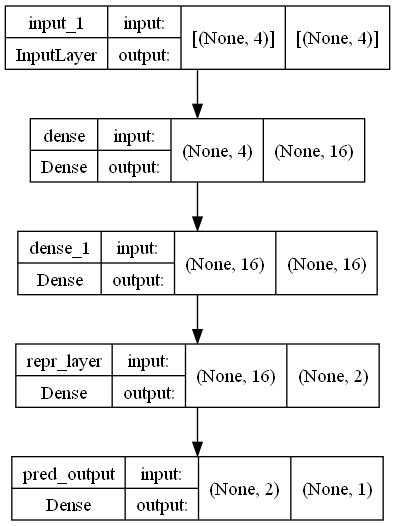

In [10]:
# Create and train the model
model = create_model([16, 16])
# summarize and plot the model
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

Epoch 1/10
32/32 [==============================] - 2s 3ms/step - loss: 1.7515
Epoch 2/10
32/32 [==============================] - 0s 4ms/step - loss: 0.9994
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.7820
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.6976
Epoch 5/10
32/32 [==============================] - 0s 4ms/step - loss: 0.6460
Epoch 6/10
32/32 [==============================] - 0s 4ms/step - loss: 0.6041
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.5668
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.5322
Epoch 9/10
32/32 [==============================] - 0s 4ms/step - loss: 0.4998
Epoch 10/10
32/32 [==============================] - 0s 3ms/step - loss: 0.4689
Groups: [0, 1, 2, 3], Min: 0, Max: 3


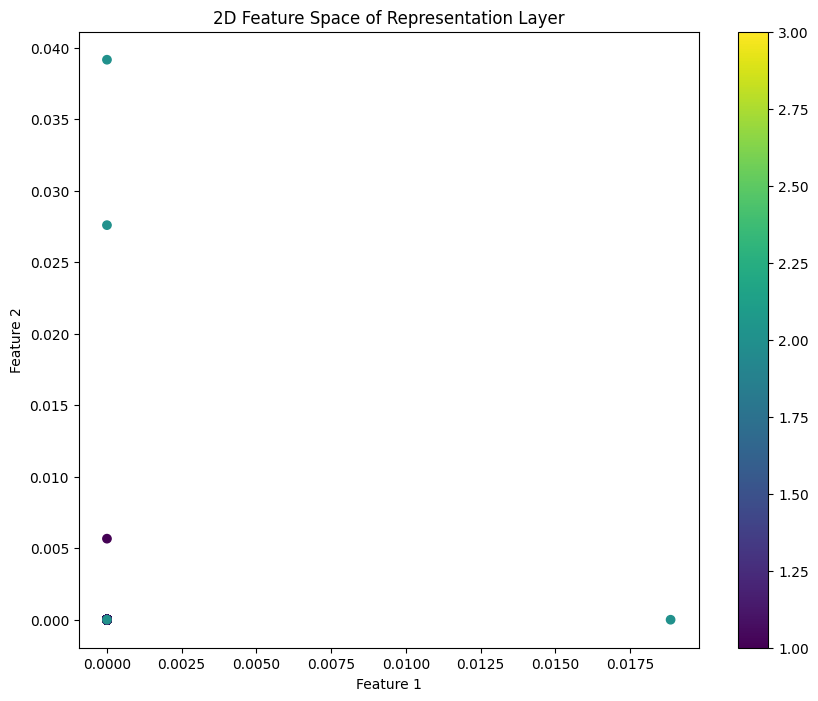

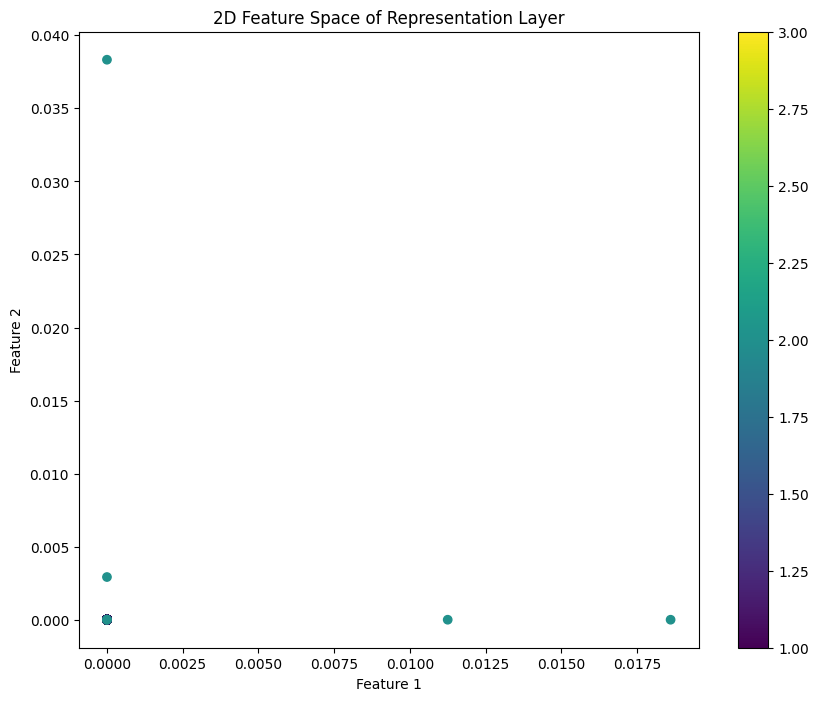

In [11]:
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=32)
# get groupings for the labels
groups, min_val, max_val = get_groups(y_train + y_test)
print(f"Groups: {groups}, Min: {min_val}, Max: {max_val}")
# Plot the 2D feature space
plot_feature_space(model, X_train, y_train, groups)
plot_feature_space(model, X_test, y_test, groups)

Test of First Idea improving on ranksim

In [91]:
def zdist(vec1: Tensor, vec2: Tensor) -> float:
    """
    Computes the squared L2 norm distance between two input feature vectors.

    :param vec1: The first input feature vector.
    :param vec2: The second input feature vector.
    :return: The squared L2 norm distance.
    """
    return tf.reduce_sum(tf.square(vec1 - vec2))


def ydist(val1: float, val2: float) -> float:
    """
    Computes the squared distance between two label values.

    :param val1: The first label value.
    :param val2: The second label value.
    :return: The squared distance.
    """
    return (val1 - val2) ** 2

def error(z1: Tensor, z2: Tensor, label1: float, label2: float) -> float:
    """
    Computes the error between the zdist of two input predicted z values and their ydist.
    Range of the error is [0, 16].

    :param z1: The predicted z value for the first input sample.
    :param z2: The predicted z value for the second input sample.
    :param label1: The label of the first input sample.
    :param label2: The label of the second input sample.
    :return: The squared difference between the zdist and ydist.
    """
    squared_difference = (zdist(z1, z2) - ydist(label1, label2)) ** 2
    return tf.reduce_sum(squared_difference)


def custom_loss(y_true, z_pred, reduction=tf.keras.losses.Reduction.SUM):
    """
    Computes the loss for a batch of predicted features and their labels.
    
    :param y_true: A batch of true label values, shape of [batch_size, 1].
    :param z_pred: A batch of predicted Z values, shape of [batch_size, 2].
    :param reduction: The type of reduction to apply to the loss.
    :return: The average error for all unique combinations of the samples in the batch.
    """
    int_batch_size = tf.shape(z_pred)[0]
    batch_size = tf.cast(int_batch_size, dtype=tf.float32)
    total_error = tf.constant(0.0, dtype=tf.float32)

    # Loop through all unique pairs of samples in the batch
    for i in tf.range(int_batch_size):
        for j in tf.range(i + 1, int_batch_size):
            z1, z2 = z_pred[i], z_pred[j]
            # tf.print(z1, z2, sep=', ', end='\n')
            label1, label2 = y_true[i], y_true[j]
            # tf.print(label1, label2, sep=', ', end='\n')
            err = error(z1, z2, label1, label2)
            # tf.print(err, end='\n\n')
            total_error += tf.cast(err, dtype=tf.float32)
    
    # tf.print(total_error)
    
    if reduction == tf.keras.losses.Reduction.SUM:
        return total_error # total loss
    elif reduction == tf.keras.losses.Reduction.NONE:
        denom = tf.cast(batch_size * (batch_size - 1) / 2 + 1e-9, dtype=tf.float32)
        # tf.print(denom)
        return total_error / denom # average loss
    else:
        raise ValueError(f"Unsupported reduction type: {reduction}.")


In [84]:
# loss mindful sanity check
# Create a batch of 3 samples
y_true = tf.constant([[1.0], [2.0], [0.0]])
z_pred = tf.constant([[0.0, 1.0], [0.552027583, 0.833825886], [0.0, 0.0]])

# find all unique pair indices
pairs = list(combinations(range(3), 2))
print(pairs)
# compute zdist and ydist for each pair
for i, j in pairs:
    print(i, j)
    print(z_pred[i], z_pred[j])
    print(zdist(z_pred[i], z_pred[j]))
    print(y_true[i], y_true[j])
    print(ydist(y_true[i], y_true[j]))
    print(error(z_pred[i], z_pred[j], y_true[i], y_true[j]))
    
# compute the average loss
print(custom_loss(y_true, z_pred))


[(0, 1), (0, 2), (1, 2)]
0 1
tf.Tensor([0. 1.], shape=(2,), dtype=float32) tf.Tensor([0.5520276 0.8338259], shape=(2,), dtype=float32)
tf.Tensor(0.3323483, shape=(), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32) tf.Tensor([2.], shape=(1,), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
tf.Tensor(0.44575882, shape=(), dtype=float32)
0 2
tf.Tensor([0. 1.], shape=(2,), dtype=float32) tf.Tensor([0. 0.], shape=(2,), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32) tf.Tensor([0.], shape=(1,), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
1 2
tf.Tensor([0.5520276 0.8338259], shape=(2,), dtype=float32) tf.Tensor([0. 0.], shape=(2,), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor([2.], shape=(1,), dtype=float32) tf.Tensor([0.], shape=(1,), dtype=float32)
tf.Tensor([4.], shape=(1,), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
9.44575882
tf.Tenso

In [107]:
class NormalizeLayer(Layer):
    def __init__(self, epsilon: float = 1e-9, **kwargs):
        """
        Initialization for the NormalizeLayer.

        :param epsilon: A small constant to prevent division by zero during normalization. Default is 1e-9.
        :param kwargs: Additional keyword arguments for the parent class.
        """
        self.epsilon = epsilon
        super(NormalizeLayer, self).__init__(**kwargs)

    def call(self, inputs: Tensor) -> Tensor:
        """
        Forward pass for the NormalizeLayer.

        :param inputs: Input tensor of shape [batch_size, ...].
        :return: Normalized input tensor of the same shape as inputs.
        """
        norm = tf.norm(inputs, axis=1, keepdims=True) + self.epsilon
        return inputs / norm

    def get_config(self) -> dict:
        """
        Returns the config of the layer. Contains the layer's configuration as a dict,
        including the `epsilon` parameter and the configurations of the parent class.

        :return: A dict containing the layer's configuration.
        """
        config = super().get_config()
        config.update({
            "epsilon": self.epsilon,
        })
        return config


In [108]:
def create_model_feat(hiddens: List[int]) -> Model:
    """
    Create a neural network model with two branches using the Keras functional API.
    One branch will be used for fitting the output to the label, and the other will use the Z features for the custom loss.
    The Z features are normalized to fit on the unit circle.

    :param hiddens: List of integers representing the number of nodes in each hidden layer.
    :return: The uncompiled model.
    """
    inputs = tf.keras.Input(shape=(4,))
    x = inputs
    # Define hidden layers according to architecture
    for nodes in hiddens:
        x = tf.keras.layers.Dense(nodes, activation='relu')(x)
     # Define the representation layer (Z features)
    repr_layer = tf.keras.layers.Dense(2, activation='relu', name='repr_layer')(x)
    # Normalize the representation layer to fit on the unit circle
    repr_layer = NormalizeLayer()(repr_layer)
    # Bundle the Z features and fitting output into a model
    enc_model = tf.keras.Model(inputs=inputs, outputs=[repr_layer])

    return enc_model


Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_14 (Dense)            (None, 16)                80        
                                                                 
 dense_15 (Dense)            (None, 16)                272       
                                                                 
 repr_layer (Dense)          (None, 2)                 34        
                                                                 
 normalize_layer_6 (Normaliz  (None, 2)                0         
 eLayer)                                                         
                                                                 
Total params: 386
Trainable params: 386
Non-trainable params: 0
____________________________________________________________

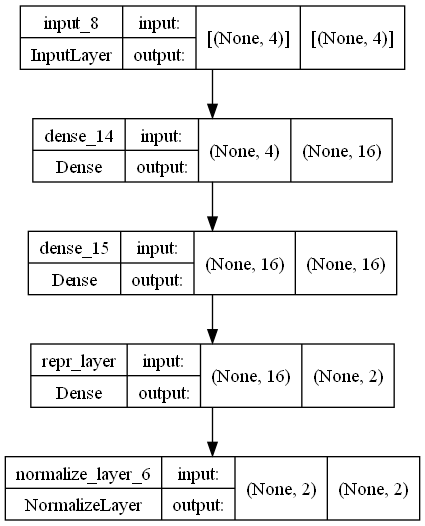

In [109]:
# Create and train the model
model_feat = create_model_feat([16, 16])
# summarize and plot the model
model_feat.summary()
tf.keras.utils.plot_model(model_feat, show_shapes=True)

In [110]:
model_feat.compile(optimizer='adam', loss=custom_loss)

[0.         0.99999744 0.99999964 0.9999997  0.9999999  0.99999994
 1.         1.0000001 ]


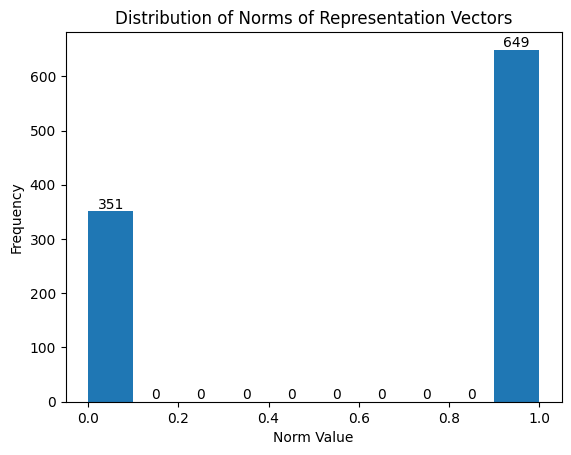

In [111]:
# mindful sanity check of the model output being normalized
reprs = model_feat.predict(X_train)
# Calculate the norms of the representation vectors
norms = np.linalg.norm(reprs, axis=1)
# Find all unique norm values
unique_norms = np.unique(norms)
# Print or otherwise use the unique norm values
print(unique_norms)
# Plot a histogram of the norms and get the patches to annotate
n, bins, patches = plt.hist(norms)

# Iterate through the patches to annotate each bar
for i in range(len(patches)):
    plt.text(patches[i].get_x() + patches[i].get_width() / 2, 
             patches[i].get_height(), 
             str(int(n[i])),
             ha='center', 
             va='bottom')
plt.title('Distribution of Norms of Representation Vectors')
plt.xlabel('Norm Value')
plt.ylabel('Frequency')
plt.show()



In [112]:
# setup tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = TensorBoard(log_dir=log_dir, histogram_freq=1)
# tensorboard --logdir logs/fit

In [126]:
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=16, restore_best_weights=True)
model_feat.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=custom_loss)
history = model_feat.fit(X_train, y_train, epochs=50, batch_size=32, callbacks=[tensorboard_cb])  

Epoch 1/50
32/32 [==============================] - 20s 563ms/step - loss: 2.1181
Epoch 2/50
32/32 [==============================] - 17s 537ms/step - loss: 1.8193
Epoch 3/50
32/32 [==============================] - 19s 597ms/step - loss: 1.9974
Epoch 4/50
32/32 [==============================] - 18s 561ms/step - loss: 1.8632
Epoch 5/50
32/32 [==============================] - 18s 546ms/step - loss: 1.7632
Epoch 6/50
32/32 [==============================] - 19s 606ms/step - loss: 1.6650
Epoch 7/50
32/32 [==============================] - 19s 603ms/step - loss: 1.9386
Epoch 8/50
32/32 [==============================] - 19s 593ms/step - loss: 1.8585
Epoch 9/50
32/32 [==============================] - 17s 528ms/step - loss: 1.8249
Epoch 10/50
32/32 [==============================] - 18s 552ms/step - loss: 1.9745
Epoch 11/50
32/32 [==============================] - 18s 559ms/step - loss: 2.2968
Epoch 12/50
32/32 [==============================] - 18s 561ms/step - loss: 2.1216
Epoch 13/50
3

In [128]:
# finetuning with lower learning rate
model_feat.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6), loss=custom_loss)
history = model_feat.fit(X_train, y_train, epochs=50, batch_size=32, callbacks=[tensorboard_cb])

Epoch 1/50
32/32 [==============================] - 20s 583ms/step - loss: 1.7433
Epoch 2/50
32/32 [==============================] - 17s 544ms/step - loss: 1.7176
Epoch 3/50
32/32 [==============================] - 18s 549ms/step - loss: 1.8255
Epoch 4/50
32/32 [==============================] - 19s 606ms/step - loss: 1.5880
Epoch 5/50
32/32 [==============================] - 19s 603ms/step - loss: 1.7580
Epoch 6/50
32/32 [==============================] - 18s 569ms/step - loss: 1.8577
Epoch 7/50
32/32 [==============================] - 19s 582ms/step - loss: 1.9736
Epoch 8/50
32/32 [==============================] - 19s 585ms/step - loss: 1.6865
Epoch 9/50
32/32 [==============================] - 17s 543ms/step - loss: 1.7223
Epoch 10/50
32/32 [==============================] - 18s 554ms/step - loss: 1.6090
Epoch 11/50
32/32 [==============================] - 18s 548ms/step - loss: 1.7662
Epoch 12/50
32/32 [==============================] - 18s 568ms/step - loss: 1.6952
Epoch 13/50
3

Groups: [0, 1, 2, 3], Min: 0, Max: 3


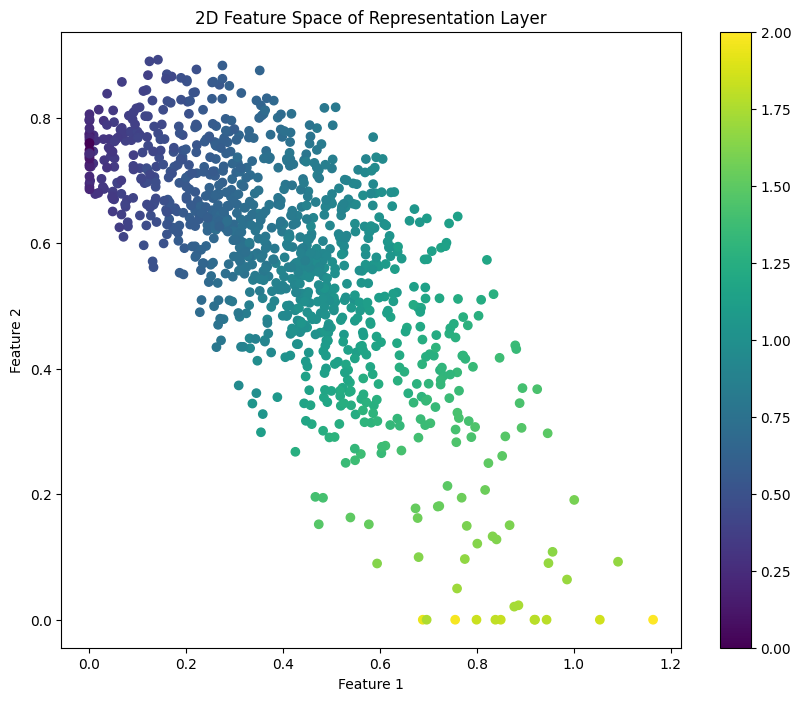

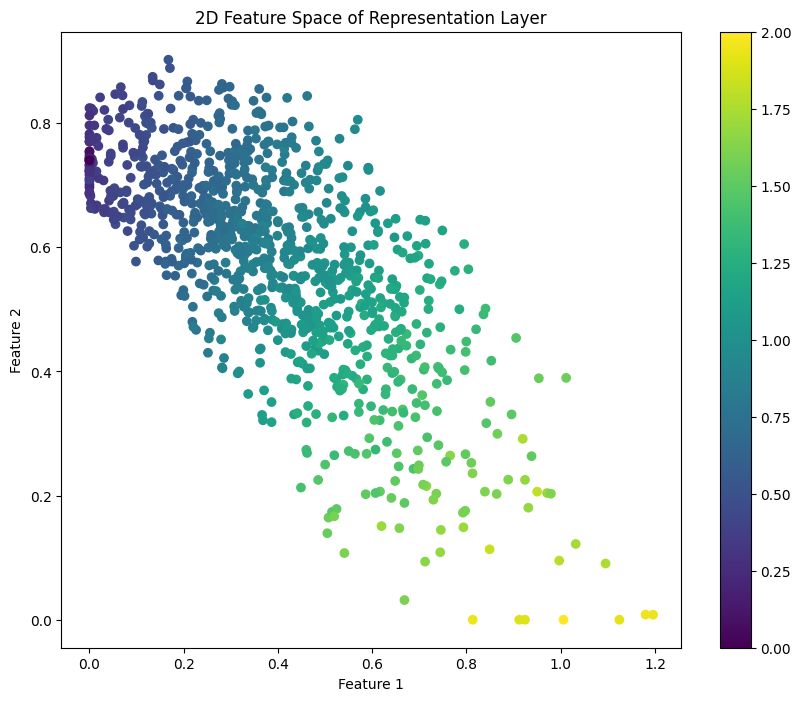

In [124]:
# get groupings for the labels
groups, min_val, max_val = get_groups(y_train + y_test)
print(f"Groups: {groups}, Min: {min_val}, Max: {max_val}")
# Plot the 2D feature space
plot_feature_space(model_feat, X_train, y_train)
plot_feature_space(model_feat, X_test, y_test)
